In [2]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [3]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['HF_DATASETS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

In [4]:
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import spacy_alignments as tokenizations
import numpy as np
import pandas as pd
import seaborn as sns
from transformer_lens.utils import gelu_fast
import math
import torch
from probing_datasets.ewt import *
from activations.activation_all import load_activation_all
from circuitsvis.tokens import colored_tokens
import einops

from analysis.plots.context_neurons import *
from analysis.plots.ngram_stimuli import *
from analysis.load_results import *

from load import *

%load_ext autoreload
%autoreload 2


%matplotlib inline

In [29]:
from activations.activation_subset import load_activation_subset
model_name = 'pythia-6.9b'
experiment_name = 'top_fact_neurons'
dataset_name = 'wikidata_sorted_occupation_athlete.pyth.128.5000'
act_dict, meta, vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
noi = pd.read_csv('interpretable_neurons/pythia-6.9b/top_fact_neurons.csv')
ds = load_feature_dataset(dataset_name)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [32]:
noi.query('dataset == @dataset_name')[['feature', 'layer', 'neuron']]#.sort_values('activation', ascending=False).head(10)

,feature,layer,neuron
0,association football player,19,10761
1,baseball player,19,549
2,baseball player,20,13139
3,baseball player,21,16105
4,American football player,20,10306
5,ice hockey player,20,2367
13,basketball player,19,3520


In [12]:
vocab_df.query('count > 10').sort_values('mean', ascending=False).tail(10)

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
122589,20,10306,36400,20.0,-4.389026,0.994596,-5.712279,-5.153582,-4.508371,-3.989745,-2.287752,Miguel
116468,20,10306,22055,13.0,-4.411915,1.845041,-8.115824,-4.963328,-4.804901,-4.129265,0.043334,esto
121495,20,10306,33414,33.0,-4.420914,1.356625,-6.670877,-5.470035,-4.790681,-3.295759,-2.150974,Pedro
123543,20,10306,39225,11.0,-4.478300,1.959850,-7.307392,-5.759456,-5.246138,-2.823894,-1.430139,stown
116908,20,10306,22919,12.0,-4.501398,1.162257,-6.222997,-5.465019,-4.353022,-3.908413,-2.316216,PF
105712,20,10306,5025,17.0,-4.656941,1.756209,-6.829513,-6.048635,-4.750423,-4.279943,0.199362,len
114655,20,10306,18582,39.0,-4.716276,0.947834,-6.899260,-5.200543,-4.739181,-4.266660,-2.526693,HP
120173,20,10306,30030,16.0,-4.785507,1.561273,-6.474440,-5.994714,-5.800631,-3.520035,-1.961341,ieder
124011,20,10306,40751,29.0,-5.077191,1.771630,-8.306555,-6.830390,-4.761900,-3.497078,-2.664403,Basketball
108943,20,10306,9404,11.0,-5.341928,1.831085,-7.103631,-6.642562,-6.053222,-4.132999,-1.383649,CS


In [14]:
for g, vdf in vocab_df.groupby(['layer', 'neuron']):
    display(vdf.query('count > 10').sort_values('mean', ascending=False).head(10))

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
36746,19,549,15661,12.0,5.175556,1.650789,2.268519,4.351773,5.425650,6.383915,7.273469,stolen
30506,19,549,6321,39.0,4.885787,2.982327,-2.342162,5.509830,6.229982,6.669542,7.303351,run
42352,19,549,26287,37.0,4.729240,1.156414,2.703755,3.646781,4.986318,5.607527,6.703194,ielder
31335,19,549,7428,23.0,4.715019,2.851950,-0.918616,5.011703,6.004293,6.459429,7.088243,walked
47274,19,549,38992,35.0,4.499631,0.900521,2.596704,3.845454,4.598188,5.226208,6.190877,batting
37023,19,549,16116,60.0,4.455417,1.986612,-1.009310,3.455115,5.257095,5.842373,7.076447,hitting
38458,19,549,18582,39.0,4.442588,1.419869,-1.131749,4.040681,4.827734,5.362000,5.842336,HP
40310,19,549,22124,36.0,4.429376,3.109279,-2.020023,2.369104,6.054691,6.368890,7.302073,handed
45190,19,549,33161,17.0,4.425725,1.473196,0.682688,3.856450,4.656374,5.170612,7.223981,pinch
33750,19,549,10903,23.0,4.366882,3.679916,-1.679170,0.412757,6.092217,7.204936,8.896441,struck


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
66110,19,3520,22919,12.0,5.706974,1.305427,4.129528,4.815377,5.345958,6.982211,7.668710,PF
72317,19,3520,37941,11.0,4.470909,2.678811,-1.012088,4.871711,5.639284,5.729334,6.788017,Lon
75177,19,3520,46879,37.0,4.394614,0.508450,2.483841,4.178658,4.509123,4.784402,5.035556,Rapt
64265,19,3520,19305,152.0,4.302040,0.809096,1.391637,3.866233,4.294681,4.945095,6.318141,NBA
69843,19,3520,31245,16.0,4.267935,2.102357,-0.941429,4.275734,4.685671,5.530505,6.469056,perimeter
73475,19,3520,41531,72.0,4.229791,1.085018,0.627567,3.752101,4.281552,4.806247,6.857524,rebounds
63618,19,3520,18145,24.0,4.225763,0.590144,3.163096,3.815325,4.284846,4.516541,5.419965,gets
56776,19,3520,7496,155.0,3.935271,3.168772,-2.734801,2.409772,4.107581,6.704314,8.577910,guard
58286,19,3520,9602,77.0,3.901638,2.513931,-1.128940,2.793588,4.793711,5.843847,7.283961,shooting
72885,19,3520,39674,27.0,3.870183,0.558944,2.684024,3.524931,3.927411,4.136384,4.802821,Bron


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
23103,19,10761,42857,72.0,5.234443,1.267261,2.167189,4.192336,5.496607,6.179815,7.836333,striker
8070,19,10761,10478,25.0,4.953839,1.620413,-2.375937,4.940451,5.295080,5.557675,6.197471,header
23648,19,10761,44568,23.0,4.836437,2.000376,-0.802618,4.778467,5.533842,5.848214,6.802377,kick
22953,19,10761,42402,63.0,4.535640,1.135111,-0.305367,3.944695,4.644886,5.445148,6.723062,midfielder
7833,19,10761,10119,30.0,4.500675,1.450638,-0.869369,4.486325,4.853400,5.108999,5.878754,loan
23905,19,10761,45405,12.0,4.361742,2.317556,1.030141,2.321307,4.648977,5.962575,7.973836,aird
20992,19,10761,36397,11.0,4.345473,1.855119,-0.806509,4.535174,4.872446,5.326047,5.589486,(£
14330,19,10761,20984,59.0,4.305314,1.230663,-1.478595,3.801358,4.441450,4.993325,6.485659,keeper
24886,19,10761,48498,50.0,4.211752,0.509001,3.098372,3.859594,4.219772,4.599631,5.145608,ottenham
14023,19,10761,20362,26.0,4.188106,1.603016,-2.444542,4.281874,4.560219,4.825745,5.687361,attacking


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
143464,20,2367,25287,17.0,5.075094,1.277486,2.833981,3.704920,5.411780,6.318430,6.521281,Quebec
134382,20,2367,9462,32.0,4.811368,1.149403,2.601230,3.883331,4.999473,5.475628,6.996640,Canadian
135603,20,2367,11282,63.0,4.523002,1.869232,-4.043669,4.645559,5.003086,5.259559,6.267091,adi
146608,20,2367,32690,11.0,4.421291,1.034878,2.840964,3.684322,4.450262,5.110929,5.986598,gary
151739,20,2367,48046,20.0,4.392863,0.956749,2.026057,4.006558,4.576567,5.081876,5.697545,Winnipeg
143129,20,2367,24604,77.0,4.146690,1.345948,0.512065,3.149351,4.185669,5.377873,6.331143,Montreal
135348,20,2367,10905,14.0,3.981939,1.312792,0.841597,3.401489,3.976266,4.658082,6.414302,onto
145363,20,2367,29539,35.0,3.972191,0.961197,1.938696,3.170069,4.137727,4.643011,5.546911,Ottawa
150794,20,2367,45053,27.0,3.964014,1.072150,1.266925,3.670932,4.115855,4.662597,5.567700,Edmonton
148287,20,2367,37304,46.0,3.963652,0.956048,1.997994,3.117516,4.004423,4.864562,5.622583,Calgary


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
111628,20,10306,13514,64.0,9.254064,3.561068,-2.471947,8.765486,10.602081,11.427924,13.064226,yard
110194,20,10306,11271,20.0,8.548598,2.858512,-0.466756,8.955268,9.331149,9.826547,10.694007,Pass
121701,20,10306,33941,11.0,8.000205,2.663627,0.394228,7.917702,8.542329,9.133902,10.694524,Running
113017,20,10306,15789,17.0,7.844197,2.784968,0.189746,7.240656,7.666840,10.161963,11.714513,yard
109806,20,10306,10690,15.0,7.679087,2.667227,0.325462,6.672273,8.819307,9.437912,10.348033,WR
103756,20,10306,2573,11.0,7.655937,3.238499,-1.482190,8.053061,8.537742,9.028189,10.237552,DE
124415,20,10306,41991,14.0,7.376239,2.581243,-0.800550,7.012074,7.851307,8.299178,10.230780,punt
120337,20,10306,30468,20.0,7.306131,2.048687,3.346642,5.115332,8.118621,8.705447,10.218287,coordinator
116664,20,10306,22443,59.0,7.174440,1.331684,2.408272,6.289808,7.304325,8.105009,9.027610,touchdown
118669,20,10306,26575,38.0,7.071869,1.912651,-1.786234,6.547080,7.455917,8.132859,9.324117,rushing


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
89256,20,13139,18582,39.0,6.287304,2.509658,-3.201596,5.346251,7.009523,7.471461,10.411020,HP
95988,20,13139,33161,17.0,4.989004,1.302159,0.912645,4.679842,5.262396,5.589272,6.800475,pinch
93150,20,13139,26287,37.0,4.677162,1.722313,1.668015,3.515651,4.263863,5.652566,9.286273,ielder
82133,20,13139,7428,23.0,4.646756,3.021569,-1.626018,4.355233,5.612027,6.524166,8.231489,walked
84548,20,13139,10903,23.0,4.519370,4.161181,-2.783661,0.263263,6.602286,7.560882,9.160354,struck
87544,20,13139,15661,12.0,4.466378,2.130378,0.692232,3.644787,5.049978,6.056262,6.735722,stolen
87821,20,13139,16116,60.0,4.451251,2.378801,-3.038788,3.690371,4.999358,6.065606,7.957116,hitting
91108,20,13139,22124,36.0,4.321867,3.388530,-3.027354,1.518892,5.943148,6.401246,7.612763,handed
93541,20,13139,27218,41.0,4.181024,1.006458,1.194941,3.789260,4.143646,4.543946,7.589477,NL
98072,20,13139,38992,35.0,4.118879,1.149765,0.384480,4.041000,4.326068,4.610633,6.270847,batting


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
157501,21,16105,6321,39.0,3.847264,2.769547,-2.040746,2.898271,4.984887,5.954019,6.853437,run
169347,21,16105,26287,37.0,3.814827,1.473828,0.304409,2.490785,4.290137,4.975809,5.781673,ielder
172185,21,16105,33161,17.0,3.624768,1.139352,0.324119,3.022011,3.599609,4.575049,5.085446,pinch
164018,21,16105,16116,60.0,3.421925,1.826214,-2.534842,2.676264,3.834904,4.663045,6.045424,hitting
167305,21,16105,22124,36.0,3.331571,2.844485,-3.546171,2.322647,4.590023,5.340719,6.373583,handed
160457,21,16105,10464,47.0,3.315355,1.140604,-0.159763,2.662855,3.344640,3.878173,5.368283,bat
174269,21,16105,38992,35.0,3.243719,0.775561,1.475325,2.604490,3.120913,3.905472,4.690469,batting
172246,21,16105,33299,48.0,3.232066,2.921995,-4.193190,2.364237,4.471866,5.031928,5.946874,fielder
156756,21,16105,5340,30.0,3.075819,0.833457,1.262492,2.660734,2.956755,3.419710,4.918940,plate
154587,21,16105,2613,102.0,3.017463,1.602075,-2.146850,2.443562,3.235089,3.874789,5.850662,base


In [33]:
noi.query('dataset == @dataset_name')[['feature', 'layer', 'neuron']]#.sort_values('activation', ascending=False).head(10)

,feature,layer,neuron
0,association football player,19,10761
1,baseball player,19,549
2,baseball player,20,13139
3,baseball player,21,16105
4,American football player,20,10306
5,ice hockey player,20,2367
13,basketball player,19,3520


In [31]:
# mapping = {
#     'association football player': 'soccer player',
#     'American football player': 'football player',
#     'ice hockey player': 'hockey player'
# }

label = np.array([ds['class']])

In [93]:
surname_spans = np.vstack([np.array(ds['surname_index_start']), np.array(ds['surname_index_end'])]).T

def get_act_df(acts, surname_spans, ds, name):
    
    max_act = []
    last_act = []
    for i, (begin, end) in enumerate(surname_spans):
        max_act.append(np.max(acts[i, begin:end+1]))
        last_act.append(acts[i, end])

    max_act = np.array(max_act)
    last_act = np.array(last_act)

    rdf = pd.DataFrame({
        'max_act': max_act,
        'last_act': last_act,
        'label': ds['class'],
        'name': ds['name'],
        'neuron': name
    })
    return rdf

rdfs = []
for layer, neuron in noi.query('dataset == @dataset_name')[['layer', 'neuron']].values:
    acts = act_dict[(layer, neuron)].dequantize().numpy().astype(np.float32)
    name = f'L{layer}.N{neuron}'
    rdf = get_act_df(acts, surname_spans, ds, name)
    rdfs.append(rdf)

rdf = pd.concat(rdfs)

In [94]:
rdf

,max_act,last_act,label,name,neuron
0,-1.083583,-2.347764,association football player,Albert Camus,L19.N10761
1,-0.963185,-0.963185,basketball player,Kobe Bryant,L19.N10761
2,-1.745773,-2.287565,association football player,Niels Bohr,L19.N10761
3,-1.083583,-1.685574,baseball player,George H. W. Bush,L19.N10761
4,2.468162,1.685574,association football player,Lionel Messi,L19.N10761
...,...,...,...,...,...
4995,0.757303,-0.344229,ice hockey player,Brady Vail,L19.N3520
4996,1.514607,1.514607,ice hockey player,Nolan Foote,L19.N3520
4997,-2.271910,-2.271910,ice hockey player,Charlie McCarthy,L19.N3520
4998,-1.308069,-1.308069,ice hockey player,Kurt Davis,L19.N3520


In [76]:
mapping = {
    'association football player': 'soccer',
    'American football player': 'football',
    'ice hockey player': 'hockey',
    'basketball player': 'basketball',
    'baseball player': 'baseball',
}

In [184]:
def plot_athlete_neurons(rdf, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(data=rdf, x='neuron', hue='label', y='max_act', whis=(1, 99), fliersize=0.2, ax=ax)
    ax.set_ylim([-5, 8.5])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=-1)
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
    ax.set_xlabel(None)
    # set grid behind plot elements
    ax.set_axisbelow(True)

    # map legend elements to labels
    handles, labels = ax.get_legend_handles_labels()
    labels = [mapping.get(l, l) for l in labels]
    ax.legend(handles, labels, loc='upper left', frameon=True, title='athlete sport', bbox_to_anchor=(0.05, 1), borderaxespad=0., fontsize=9)
    ax.set_ylabel('max pre-activation of surname')

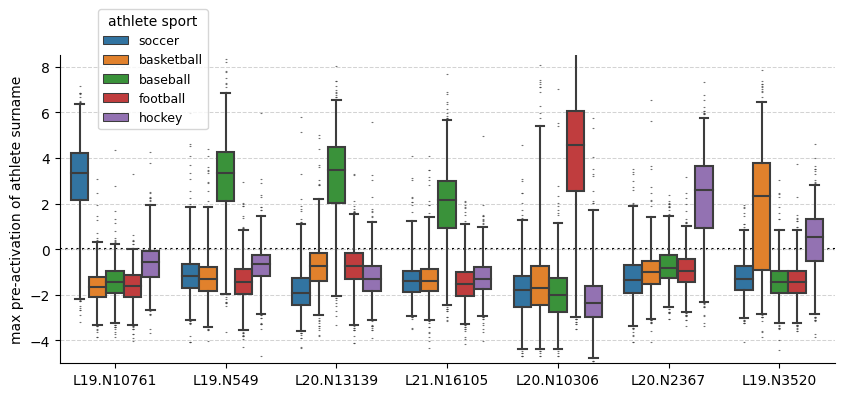

In [180]:
plot_athlete_neurons(rdf)

In [189]:
rdf = rdf.query('neuron != "L21.N16105"')

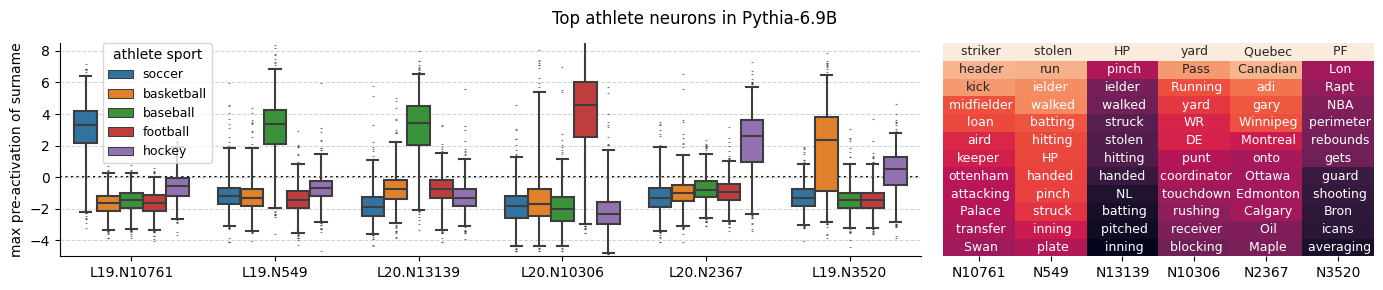

In [194]:

fig, axs = plt.subplots(1, 2, figsize=(14, 3), gridspec_kw={'width_ratios': [2, 1]})
# make font smaller
plot_athlete_neurons(rdf, ax=axs[0])

order = [(int(t.get_text().split('.')[0][1:]), int(t.get_text().split('.')[1][1:])) for t in axs[0].get_xticklabels()]

activation_matrix, token_matrix = get_vocab_plot_data(vocab_df, top_k=12, order=order)
sns.heatmap(activation_matrix, annot=token_matrix,  fmt='', annot_kws={'fontsize': 9}, ax=axs[1], cbar=False)
# turn off yticks and ylabel
axs[1].set_yticks([])
axs[1].set_xticklabels([t.get_text().split('.')[1] for t in axs[0].get_xticklabels()], rotation=0, fontsize=10)

plt.suptitle('Top athlete neurons in Pythia-6.9B', fontsize=12, y=0.95)

plt.tight_layout()

plt.savefig('figures/athlete_neurons.png', bbox_inches='tight')

In [187]:
# Text to str


In [104]:
n1 = act_dict[(19, 549)].dequantize().numpy().astype(np.float32)
n2 = act_dict[(20, 13139)].dequantize().numpy().astype(np.float32)
n3 = act_dict[(21, 16105)].dequantize().numpy().astype(np.float32)
baseball_sup = np.maximum(n1, 0) + np.maximum(n2, 0) + np.maximum(n3, 0)
baseball_gelu = np.array(gelu_fast(torch.tensor(n1)) + gelu_fast(torch.tensor(n2)) + gelu_fast(torch.tensor(n3)))

In [105]:
bbsup_df = get_act_df(baseball_gelu, surname_spans, ds, 'baseball_sup')

(array([303., 628.,  34.,  11.,   4.,   0.,   4.,   2.,   2.,   1.,   0.,
          1.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.46835476, -0.16892327,  0.13050821,  0.42993969,  0.72937119,
         1.02880263,  1.3282342 ,  1.62766564,  1.92709708,  2.22652864,
         2.52596021,  2.82539153,  3.12482309,  3.42425466,  3.72368598,
         4.02311754,  4.32254887,  4.62198067,  4.92141199,  5.22084332,
         5.52027512,  5.81970644,  6.11913776,  6.41856956,  6.71800089,
         7.01743221,  7.31686401,  7.61629534,  7.91572666,  8.21515846,
         8.51459026,  8.81402111,  9.11345291,  9.41288471,  9.71231556,
        10.01174736, 10.31117916, 10.61061001, 10.91004181, 11.20947361,
        11.50890446, 11.80833626, 12.10776806, 12.40719891, 12.70663071,
 

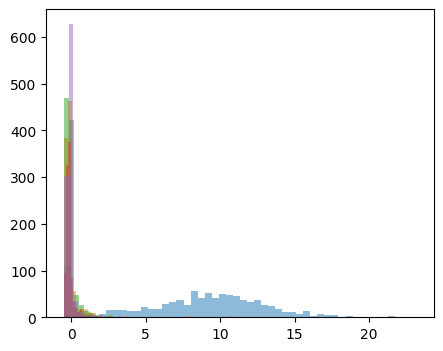

In [112]:
# plot hist for each label
fig, ax = plt.subplots(figsize=(5, 4))
plt.hist(bbsup_df.query('label == "baseball player"')['max_act'], bins=50, alpha=0.5, label='baseball player')
plt.hist(bbsup_df.query('label == "basketball player"')['max_act'], bins=50, alpha=0.5, label='basketball player')
plt.hist(bbsup_df.query('label == "ice hockey player"')['max_act'], bins=50, alpha=0.5, label='ice hockey player')
plt.hist(bbsup_df.query('label == "American football player"')['max_act'], bins=50, alpha=0.5, label='American football player')
plt.hist(bbsup_df.query('label == "association football player"')['max_act'], bins=50, alpha=0.5, label='association football player')

<AxesSubplot: xlabel='label', ylabel='max_act'>

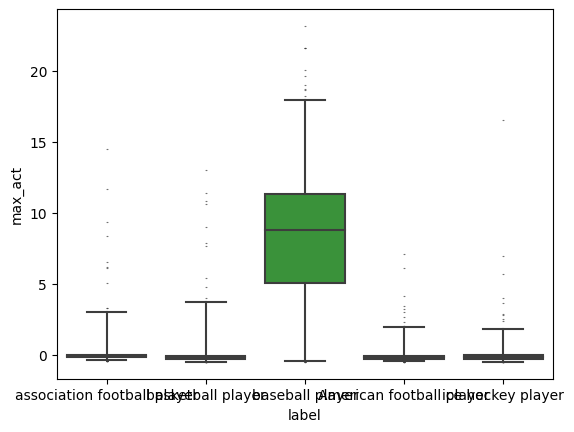

In [109]:
sns.boxplot(data=bbsup_df, x='label', y='max_act', whis=(1, 99), fliersize=0.2)

In [113]:
vocab_df

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
0,19,10761,0,64650.0,-0.881147,0.003245,-0.908346,-0.883382,-0.880193,-0.878716,-0.844688,<|endoftext|>
1,19,10761,2,122.0,-1.020187,1.648883,-3.486031,-2.061801,-1.401195,-0.673822,4.218526,!
2,19,10761,3,558.0,-0.986877,1.702914,-4.207223,-1.967253,-1.406133,-0.740475,5.395905,""""
3,19,10761,4,7.0,-1.254845,1.230005,-2.859841,-1.852621,-1.336360,-0.968877,1.055284,#
4,19,10761,5,5.0,-1.405001,0.410532,-1.919299,-1.625449,-1.485049,-1.104132,-0.891078,$
...,...,...,...,...,...,...,...,...,...,...,...,...
177788,21,16105,50272,21.0,-2.012545,0.726742,-3.231381,-2.618719,-1.834668,-1.494941,-0.960809,
177789,21,16105,50273,4.0,-1.725991,0.562394,-2.224793,-2.164187,-1.820396,-1.382200,-1.038376,
177790,21,16105,50274,28.0,-2.374076,0.913860,-3.918102,-2.971630,-2.227842,-1.693766,-0.766017,
177791,21,16105,50275,71.0,-1.588908,0.924685,-4.199385,-2.084325,-1.542847,-0.985733,1.864269,


In [163]:
def get_vocab_plot_data(vocab_df, top_k=12, order=None):
    vocab_plot_data = {}
    for g, vdf in vocab_df.groupby(['layer', 'neuron']):
        vdf['is_alpha'] = vdf['string'].apply(lambda s: str(s).strip().isalpha())
        vocab_plot_data[g] = vdf.query('count > 10 and is_alpha').sort_values('mean', ascending=False).head(top_k)[['mean', 'string']]

    if order is not None:
        ns = order
    else:
        ns = list(vocab_plot_data.keys())

    activation_matrix = np.zeros((len(ns), top_k))
    token_matrix = np.zeros((len(ns), top_k), dtype=object)
    for i, n in enumerate(ns):
        activation_matrix[i, :] = vocab_plot_data[n]['mean'].values
        token_matrix[i, :] = vocab_plot_data[n]['string'].values


    activation_matrix = activation_matrix.T
    token_matrix = token_matrix.T

    # normalize activations
    activation_matrix = activation_matrix / np.max(activation_matrix, axis=0)

    return activation_matrix, token_matrix

<AxesSubplot: >

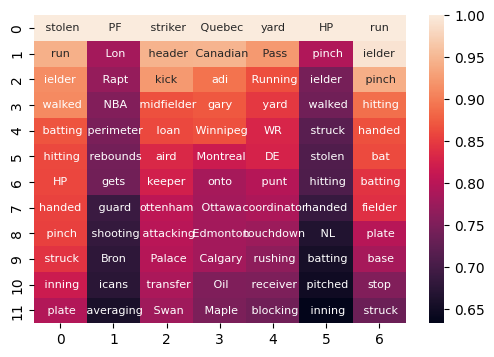

In [148]:
activation_matrix, token_matrix = get_vocab_plot_data(vocab_df, top_k=12)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
# make font smaller
sns.heatmap(activation_matrix, annot=token_matrix,  fmt='', annot_kws={'fontsize': 8})

[(19, 549),
 (19, 3520),
 (19, 10761),
 (20, 2367),
 (20, 10306),
 (20, 13139),
 (21, 16105)]

array([-1.0835835 , -0.9631853 , -1.7457733 , ..., -1.6253753 ,
       -0.48159266, -0.6019908 ], dtype=float32)

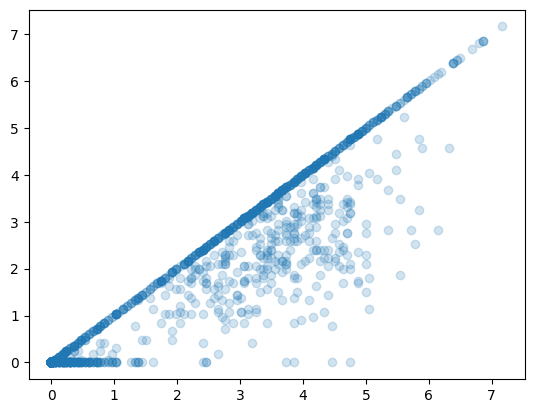

In [52]:
plt.scatter(np.maximum(max_act, 0), np.maximum(last_act, 0), alpha=0.2)

In [28]:
act_dict

{(19,
  10761): tensor([[-0.9030, -2.2274, -0.7224,  ..., -1.0836, -1.0836, -2.3478],
         [-0.9030, -0.7826, -1.5652,  ..., -2.2876, -1.5050, -0.9632],
         [-0.9030, -1.5050, -1.5652,  ..., -1.8060, -1.7458, -2.2876],
         ...,
         [-0.9030, -0.1806, -1.3244,  ...,  0.3010, -0.5418, -1.6254],
         [-0.9030, -0.2408, -0.4816,  ..., -0.9030, -0.9030, -0.9030],
         [-0.9030, -0.8428, -1.8662,  ..., -2.7090, -0.6020, -2.1672]],
        size=(5000, 128), dtype=torch.quint8,
        quantization_scheme=torch.per_tensor_affine, scale=0.06019908119650448,
        zero_point=99),
 (19,
  549): tensor([[-0.9858, -0.5915, -2.4973,  ..., -1.3144, -1.0515, -2.0373],
         [-0.9858, -1.4458, -1.1172,  ..., -2.1687, -3.1545, -2.5630],
         [-0.9858, -1.8401, -0.7229,  ..., -2.6287, -2.5630, -2.4316],
         ...,
         [-0.9858, -0.4600, -1.9058,  ..., -1.7744, -1.1829, -0.8543],
         [-0.9858, -1.3801, -1.2486,  ..., -0.9858, -0.9858, -0.9858],
         [-0

In [27]:
ds

Dataset({
    features: ['name', 'text', 'tokens', 'name_index_start', 'name_index_end', 'surname_index_start', 'surname_index_end', 'class'],
    num_rows: 5000
})

In [16]:
dataset_name = 'wikidata_sorted_occupation.pyth.128.6000'
act_dict, meta, vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
for g, vdf in vocab_df.groupby(['layer', 'neuron']):
    display(vdf.query('count > 10').sort_values('mean', ascending=False).head(10))

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
118709,9,613,24508,12.0,5.590303,1.067738,4.091806,4.802967,5.602506,6.316182,7.270987,election
119714,9,613,26058,11.0,4.865959,0.592660,4.032130,4.530956,4.872715,5.054028,6.255037,MPs
108623,9,613,10544,29.0,4.830240,1.368752,0.140914,4.332923,5.011019,5.597829,7.091197,elected
107286,9,613,8907,47.0,4.797701,0.697712,3.443959,4.385967,4.746330,5.222348,6.718775,Senate
114796,9,613,18718,29.0,4.383783,0.946621,2.076990,3.924318,4.482878,4.896117,5.914290,Senator
104952,9,613,6132,82.0,4.278856,1.198426,-0.612869,3.376461,4.455768,5.127154,6.334775,election
110055,9,613,12337,23.0,4.265678,0.912485,2.532077,3.556423,4.579301,4.942617,5.692668,elections
123129,9,613,31650,11.0,4.236557,0.780684,2.675310,3.787055,4.059622,4.960412,5.158894,senators
101974,9,613,2719,34.0,4.220059,2.339677,-0.931202,3.064550,5.385288,5.840553,6.647467,Rep
110691,9,613,13171,25.0,4.068201,1.295967,1.834771,3.109290,4.211486,5.082190,6.066794,Parliament


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
74450,9,3974,9311,22.0,4.509533,0.916009,2.975312,3.740450,4.772004,5.123786,6.292271,publication
69827,9,3974,3863,105.0,3.982646,0.788059,1.780419,3.467400,4.110786,4.541808,5.346349,published
70902,9,3974,5098,89.0,3.916578,0.932749,-0.359205,3.457711,4.000710,4.479562,5.708575,books
79750,9,3974,16103,20.0,3.900859,1.536806,1.329301,3.291164,3.934151,4.476307,7.228771,Books
68138,9,3974,1984,218.0,3.813693,0.960515,-1.346581,3.460464,3.879252,4.346511,5.879009,book
76096,9,3974,11338,49.0,3.603347,0.839568,1.237388,3.185802,3.692215,4.195002,5.385180,magazine
73174,9,3974,7774,17.0,3.533310,1.199888,0.289743,2.983995,3.746424,4.139467,5.243781,articles
68596,9,3974,2488,90.0,3.355469,1.470527,-1.781245,2.876472,3.873819,4.193438,5.236240,author
95633,9,3974,42250,29.0,3.350573,0.588396,2.340901,3.000639,3.305893,3.663429,4.478140,novelist
76262,9,3974,11547,30.0,3.342374,0.696857,1.394975,2.987024,3.365541,3.749918,4.765892,newspaper


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
59879,9,4502,37160,16.0,4.274050,0.488552,3.664788,3.915747,4.100775,4.585947,5.491649,Film
46187,9,4502,15573,22.0,4.170803,0.749542,1.871193,4.001763,4.409449,4.656018,5.007110,cin
45294,9,4502,14359,11.0,4.162515,0.626045,2.992916,3.849910,4.087481,4.636109,4.974226,emat
49726,9,4502,20541,15.0,4.042029,0.741953,2.800553,3.586729,3.741734,4.623514,5.328197,footage
57311,9,4502,32539,12.0,3.866450,0.635058,2.919655,3.469578,3.617307,4.295302,4.941292,filming
37914,9,4502,5304,11.0,3.800072,0.896910,2.486938,3.098038,3.923481,4.436469,5.036270,visual
36423,9,4502,3601,66.0,3.709669,1.003882,-1.127187,3.282871,3.942205,4.404197,5.444210,screen
54719,9,4502,28193,200.0,3.543607,0.527425,2.022790,3.177818,3.593809,3.925031,4.839638,starring
35960,9,4502,3085,574.0,3.410732,0.614473,1.541516,3.014028,3.346220,3.817774,5.556913,film
53782,9,4502,26693,22.0,3.342842,0.621283,2.475199,3.024920,3.164267,3.745477,5.252574,cinema


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
28010,9,12997,39674,17.0,4.912135,2.216328,0.155465,5.248920,5.663958,6.022913,7.210750,Bron
24838,9,12997,33742,20.0,4.574080,1.611213,-0.684810,4.445622,4.996071,5.283730,7.137029,inho
21171,9,12997,27593,13.0,4.385675,1.182613,0.923340,4.109479,4.608682,5.110586,5.512642,assists
20657,9,12997,26762,19.0,4.304623,1.568354,-1.570982,4.054621,4.356138,4.980228,5.899203,defender
15698,9,12997,19305,38.0,4.222993,0.373354,3.390425,4.023671,4.272078,4.526515,5.130400,NBA
32340,9,12997,48498,19.0,4.102032,1.026882,0.076732,4.160031,4.282506,4.494985,5.062003,ottenham
29606,9,12997,42857,29.0,4.013781,1.033567,-0.909639,3.814101,4.172258,4.499841,5.057566,striker
24626,9,12997,33386,43.0,3.948347,0.975790,-0.867336,3.518794,3.811578,4.500344,5.858299,Arsenal
28604,9,12997,40860,21.0,3.916167,0.683135,2.760535,3.617688,3.877439,4.379767,5.463973,midfield
21242,9,12997,27705,16.0,3.906559,0.692256,2.534561,3.313405,4.207585,4.448719,4.753958,Sox


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
143433,11,12667,12609,63.0,4.988591,0.910881,2.363560,4.441847,4.956473,5.632313,6.791916,guitar
151309,11,12667,23599,42.0,4.971708,1.079062,2.357276,4.442470,4.923672,5.737973,7.321131,vocals
158220,11,12667,35015,12.0,4.866790,1.952328,-0.289420,4.511258,5.349635,6.259107,6.604887,Sessions
153654,11,12667,27275,14.0,4.389548,0.803297,2.457442,4.157977,4.475708,4.717374,5.756563,drums
161204,11,12667,40720,33.0,4.301259,1.033153,1.821694,3.696066,4.368501,4.879415,6.195402,guitarist
159078,11,12667,36567,14.0,4.273189,0.608159,3.380244,3.843969,4.180629,4.345083,5.590085,uitar
138721,11,12667,6844,12.0,4.145269,2.519750,-1.153213,3.592697,4.604600,5.620725,7.632956,")"""
137510,11,12667,5400,254.0,4.140580,0.940636,-0.451974,3.690493,4.276555,4.701613,6.091462,album
156761,11,12667,32428,31.0,3.989645,1.027653,-0.110050,3.740172,4.159092,4.597936,5.486780,blues
146914,11,12667,17241,34.0,3.981620,2.173987,-1.673659,3.330469,4.795254,5.317087,6.551744,Country


In [17]:
dataset_name = 'wikidata_sorted_sex_or_gender.pyth.128.6000'
act_dict, meta, vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
for g, vdf in vocab_df.groupby(['layer', 'neuron']):
    display(vdf.query('count > 10').sort_values('mean', ascending=False).head(10))

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
18998,9,996,24958,14.0,2.483162,0.899499,-0.301567,2.388785,2.569272,2.879747,3.813312,Abraham
24431,9,996,34343,21.0,2.223465,0.642995,0.752177,1.885794,2.262959,2.700914,3.340532,Caesar
24911,9,996,35243,13.0,2.218508,1.283372,-0.840007,2.103865,2.581354,2.873457,4.050462,anan
25060,9,996,35544,28.0,2.108896,0.774266,-1.313420,2.128405,2.271330,2.408167,3.063544,Maurice
9047,9,996,10666,20.0,2.020585,1.374624,-2.549998,2.163306,2.534822,2.688773,2.951730,ethe
25890,9,996,37177,11.0,1.976047,0.643197,0.774022,1.914793,2.121883,2.322400,2.792698,Milton
24655,9,996,34762,17.0,1.887993,0.763471,-0.407934,1.703564,1.924649,2.089885,3.200289,ubert
22931,9,996,31580,16.0,1.865319,0.874385,-0.235666,1.657936,1.819454,2.282790,3.495547,Walt
21514,9,996,29161,14.0,1.856008,0.525359,0.906310,1.481653,1.942733,2.270899,2.592065,Stalin
22272,9,996,30435,22.0,1.844765,0.547248,0.566699,1.662802,1.938036,2.125266,2.861033,Freud


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
34837,12,4043,2993,90.0,5.267325,0.941621,2.982987,4.663595,5.147278,5.833494,7.432038,She
37527,12,4043,6122,75.0,5.162287,1.485649,1.354879,4.148132,5.148404,6.304835,8.247253,daughter
35039,12,4043,3226,59.0,4.996400,0.817390,2.990076,4.398490,4.833845,5.607619,6.678872,girl
41289,12,4043,10759,34.0,4.858378,1.379405,1.198034,4.184174,4.867790,5.943905,7.740736,Her
41234,12,4043,10692,16.0,4.752382,1.475907,0.917474,4.249425,4.982858,5.386320,6.655259,lady
33514,12,4043,1500,307.0,4.730726,1.182950,2.376836,3.919996,4.663439,5.459270,7.741825,She
40811,12,4043,10137,21.0,4.709288,0.651831,3.351659,4.362880,4.795092,5.113826,6.344626,Ms
55623,12,4043,32518,12.0,4.705596,1.568631,2.275803,3.516616,4.505130,5.923065,7.279112,ska
32774,12,4043,703,723.0,4.663423,1.327709,-0.536279,3.666742,4.592678,5.678238,9.187024,she
56964,12,4043,35028,20.0,4.597787,0.856963,3.509703,4.145072,4.576059,4.801551,7.810900,Louise


In [20]:
dataset_name = 'wikidata_sorted_is_alive.pyth.128.6000'
act_dict, meta, vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
for g, vdf in vocab_df.groupby(['layer', 'neuron']):
    display(vdf.query('count > 10').sort_values('mean', ascending=False).head(10))

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
60365,14,205,40971,11.0,1.641000,0.208149,1.344489,1.503817,1.609080,1.779234,2.012881,Nietzsche
64459,14,205,49531,11.0,1.640192,0.647908,0.581070,1.335491,1.457097,2.182617,2.528058,Truman
62683,14,205,45750,12.0,1.584938,0.328740,0.895739,1.405332,1.644010,1.793824,1.998492,1937
43931,14,205,13918,34.0,1.564823,0.509141,0.713521,1.183453,1.582454,1.823125,2.740908,1950
54269,14,205,29628,26.0,1.506882,0.910798,-0.528478,0.813053,1.454081,2.174309,3.064146,atra
56170,14,205,32921,18.0,1.484681,0.556887,0.436085,1.200557,1.584340,1.680057,2.710341,1924
57473,14,205,35364,12.0,1.481886,0.691862,-0.016950,1.239679,1.389081,1.958589,2.667046,1957
50101,14,205,22824,15.0,1.467419,0.475214,0.815770,1.078731,1.467903,1.750742,2.283951,1959
47162,14,205,18417,25.0,1.433131,0.577929,0.258809,1.021984,1.409213,1.613213,2.983717,1965
50028,14,205,22716,18.0,1.429596,0.270750,0.909062,1.260751,1.494458,1.624168,1.825350,1956


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
10176,17,5653,12140,37.0,1.868119,0.494159,0.713656,1.601268,2.000695,2.242242,2.691011,1986
12142,17,5653,14752,17.0,1.776336,0.490923,0.977978,1.500483,1.628290,2.226074,2.820466,1975
10097,17,5653,12034,17.0,1.761291,0.582451,0.784761,1.424312,1.590412,2.201694,2.811116,1987
31928,17,5653,49244,11.0,1.751986,0.386377,1.068182,1.521999,1.749517,2.064662,2.271017,MTV
7869,17,5653,9178,58.0,1.748998,0.711689,-0.830304,1.358753,1.812817,2.249207,2.984404,1980
11470,17,5653,13842,22.0,1.715212,0.686777,-0.289429,1.451698,1.773298,2.038977,3.162904,1979
11818,17,5653,14304,18.0,1.674758,0.661587,-0.002573,1.374195,1.779195,2.042028,2.623996,1978
12759,17,5653,15621,20.0,1.652412,0.508422,0.669756,1.174914,1.646151,2.141619,2.500620,1973
12229,17,5653,14880,11.0,1.606443,0.585182,-0.024601,1.524115,1.718126,1.893418,2.185318,1986
9699,17,5653,11513,38.0,1.600548,0.513493,0.511306,1.333994,1.664844,1.945754,2.542129,1988


In [21]:
dataset_name = 'wikidata_sorted_political_party.pyth.128.3000'
act_dict, meta, vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
for g, vdf in vocab_df.groupby(['layer', 'neuron']):
    display(vdf.query('count > 10').sort_values('mean', ascending=False).head(10))

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
33112,7,3710,14124,17.0,4.450359,0.360463,3.815321,4.137162,4.508606,4.803935,4.877334,unes
44997,7,3710,45041,19.0,3.508087,1.077139,1.595584,2.649010,3.550953,4.378458,5.176867,Bolton
42071,7,3710,35015,18.0,2.828151,0.574815,1.787903,2.613437,2.868872,3.257204,3.678079,Sessions
23688,7,3710,662,14.0,2.695681,0.999856,0.609237,2.345981,2.978827,3.123929,3.972921,urn
35591,7,3710,18749,19.0,2.691226,0.922069,0.331633,2.470286,2.842462,3.312161,3.803043,Baker
43064,7,3710,38085,13.0,2.360985,0.771751,0.835308,1.964876,2.210036,3.053147,3.535439,ultz
43175,7,3710,38488,13.0,2.242836,1.123636,-0.214303,1.592942,2.199319,3.296084,3.376930,Daniels
36915,7,3710,21568,12.0,2.224713,1.441670,0.223711,0.545679,2.883944,3.346941,3.985557,emp
32398,7,3710,12916,15.0,2.204174,0.992759,-0.279262,1.695766,1.907688,2.942432,3.539970,wing
29513,7,3710,8329,16.0,2.148608,0.573087,1.068770,1.966674,2.264219,2.499639,2.810856,umer


,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
11211,18,15606,16442,24.0,1.832081,0.559786,0.314882,1.622929,1.930389,2.218446,2.609483,McG
14984,18,15606,24465,20.0,1.670289,0.599864,0.070698,1.706844,1.848712,1.920266,2.386019,Gill
8646,18,15606,11957,19.0,1.482948,0.768141,-0.017910,1.094543,1.565623,2.026163,2.877816,Ros
11318,18,15606,16610,19.0,1.369969,1.561123,-1.587097,0.315031,2.043557,2.363052,3.158951,wage
4437,18,15606,5611,47.0,1.309345,0.714611,-0.188617,0.801794,1.230164,1.854427,3.144124,introduced
12197,18,15606,18308,75.0,1.209525,0.480360,-0.031883,0.877665,1.198592,1.502212,2.263935,Mayor
4658,18,15606,5927,13.0,1.208298,1.158745,-0.973158,0.711915,1.541718,2.007487,2.534866,minimum
5057,18,15606,6493,16.0,1.151324,0.753385,-0.268195,0.540312,1.084565,1.766224,2.542497,projects
9127,18,15606,12751,17.0,1.098426,0.718821,-0.607633,0.801891,1.090693,1.316313,2.575242,Ren
6043,18,15606,7903,13.0,1.085037,0.491195,-0.224101,1.047527,1.108392,1.275945,1.771614,Max


In [9]:
act_dict

{(19,
  10761): tensor([[-0.9030, -2.2274, -0.7224,  ..., -1.0836, -1.0836, -2.3478],
         [-0.9030, -0.7826, -1.5652,  ..., -2.2876, -1.5050, -0.9632],
         [-0.9030, -1.5050, -1.5652,  ..., -1.8060, -1.7458, -2.2876],
         ...,
         [-0.9030, -0.1806, -1.3244,  ...,  0.3010, -0.5418, -1.6254],
         [-0.9030, -0.2408, -0.4816,  ..., -0.9030, -0.9030, -0.9030],
         [-0.9030, -0.8428, -1.8662,  ..., -2.7090, -0.6020, -2.1672]],
        size=(5000, 128), dtype=torch.quint8,
        quantization_scheme=torch.per_tensor_affine, scale=0.06019908119650448,
        zero_point=99),
 (19,
  549): tensor([[-0.9858, -0.5915, -2.4973,  ..., -1.3144, -1.0515, -2.0373],
         [-0.9858, -1.4458, -1.1172,  ..., -2.1687, -3.1545, -2.5630],
         [-0.9858, -1.8401, -0.7229,  ..., -2.6287, -2.5630, -2.4316],
         ...,
         [-0.9858, -0.4600, -1.9058,  ..., -1.7744, -1.1829, -0.8543],
         [-0.9858, -1.3801, -1.2486,  ..., -0.9858, -0.9858, -0.9858],
         [-0

In [14]:
experiment_name = 'test_full_sparsity_sweep'
results_dir = 'results'
inner_loop = 'telescopic_sparsity_sweep'

PYTHIA_MODELS=['pythia-70m', 'pythia-160m', 'pythia-410m', 'pythia-1b', 'pythia-1.4b', 'pythia-2.8b', 'pythia-6.9b']

feature_datasets = [
    'wikidata_sorted_is_alive.pyth.128.6000',
    'wikidata_sorted_occupation.pyth.128.6000',
    'wikidata_sorted_occupation_athlete.pyth.128.5000',
    'wikidata_sorted_political_party.pyth.128.3000',
    'wikidata_sorted_sex_or_gender.pyth.128.6000'
]
sparsity_sweep_results = {}
for model in PYTHIA_MODELS:
    for dataset in feature_datasets:
        results_dict, config = load_probing_experiment_results(results_dir, experiment_name, model, dataset, inner_loop, uncollapse_features=True)
        sparsity_sweep_results[model, dataset] = results_dict

In [58]:
sparsity_rdict = {}
for k1, v1 in sparsity_sweep_results.items():
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():
            sparsity_rdict[k1 + k2 + (k3, )] = v3

srdf = pd.DataFrame(sparsity_rdict).T
srdf.index.names = ['model', 'dataset', 'feature', 'layer', 'agg', 'loc', 'k']
mono_df = srdf.sort_values('test_f1_score', ascending=False).query('k==1')

columns_of_interest = ['test_mcc', 'test_f1_score', 'test_precision', 'test_recall', 'coef', 'neuron']
mono_df.coef = mono_df.coef.apply(lambda x: x[0])
mono_df['neuron'] = mono_df.support.apply(lambda x: x[0])
mono_df = mono_df[columns_of_interest]

In [69]:
top_athlete = mono_df.query('dataset == "wikidata_sorted_occupation_athlete.pyth.128.5000" and model=="pythia-6.9b"').head(6)
top_features = mono_df.query('model=="pythia-6.9b" and coef > 0 and layer <= 20').groupby('feature').head(1)

In [74]:
# drop duplicate features
top_fact_neurons = pd.concat([top_athlete, top_features])
top_fact_neurons = top_fact_neurons.drop_duplicates('neuron')

In [77]:
top_fact_neurons.reset_index().to_csv('interpretable_neurons/pythia-6.9b/top_fact_neurons.csv', index=False)

In [41]:
srdf.query('dataset == "wikidata_sorted_occupation.pyth.128.6000" and model=="pythia-6.9b" and k <= 6 and layer==19').sort_values('test_f1_score', ascending=False).head(10)

test_mcc  \
model       dataset                                  feature layer agg loc           k             
pythia-6.9b wikidata_sorted_occupation.pyth.128.6000 athlete 19    max mlp.hook_post 6  0.808015   
                                                                                     5  0.807673   
                                                                                     4   0.80376   
                                                                                     3  0.802733   
                                                                                     2  0.792859   
                                                     actor   19    max mlp.hook_post 6   0.68107   
                                                                                     2  0.664431   
                                                                                     3  0.664323   
                                                                                     4  0.663083   
                                                                                     5  0.663002   

                                                                                       test_cohen_kappa  \
model       dataset                                  feature layer agg loc           k                    
pythia-6.9b wikidata_sorted_occupation.pyth.128.6000 athlete 19    max mlp.hook_post 6         0.806685   
                                                                                     5          0.80613   
                                                                                     4         0.802436   
                                                                                     3         0.800723   
                                                                                     2         0.789721   
                                                     actor   19    max mlp.hook_post 6         0.673177   
                                                                                     2         0.657843   
                                                                                     3         0.657269   
                                                                                     4         0.655883   
                                                                                     5         0.655318   

                                                                                        test_fmi  \
model       dataset                                  feature layer agg loc           k             
pythia-6.9b wikidata_sorted_occupation.pyth.128.6000 athlete 19    max mlp.hook_post 6  0.837609   
                                                                                     5   0.83718   
                                                                                     4  0.834015   
                                                                                     3  0.832711   
                                                                                     2  0.823714   
                                                     actor   19    max mlp.hook_post 6  0.740792   
                                                                                     2  0.726964   
                                                                                     3  0.727051   
                                                                                     4  0.726106   
                                                                                     5   0.72621   

                                                                                       test_f1_score  \
model       dataset                                  feature layer agg loc           k                 
pythia-6.9b wikidata_sorted_occupation.pyth.128.6000 athlete 19    max mlp.hook_post 6      0.836625   
                                                                                     5   

In [9]:
columns_of_interest = ['test_mcc', 'test_f1_score', 'test_precision', 'test_recall', 'coef']
monordf = pd.concat(rdfs.values(), keys=rdfs.keys(), names=['model', 'dataset'])[columns_of_interest]
monordf.coef = monordf.coef.apply(lambda x: x[0])

In [10]:
factdf = monordf.loc[monordf.index.get_level_values('dataset').str.startswith('wikidata')] 

In [11]:
factdf.sort_values('test_mcc', ascending=False).groupby(['model', 'dataset', 'feature']).head(1).head(50)

test_mcc  \
model       dataset                                          feature                     layer aggregation hook_loc      neuron             
pythia-6.9b wikidata_sorted_sex_or_gender.pyth.128.6000      male                        12    max         mlp.hook_post 5       0.982261   
                                                             female                      12    max         mlp.hook_post 5       0.982261   
pythia-2.8b wikidata_sorted_sex_or_gender.pyth.128.6000      male                        17    max         mlp.hook_post 128     0.975556   
                                                             female                      17    max         mlp.hook_post 128     0.975556   
pythia-1b   wikidata_sorted_sex_or_gender.pyth.128.6000      male                        10    max         mlp.hook_post 4       0.972324   
                                                             female                      10    max         mlp.hook_post 4       0.972324   
pythia-1.4b wikidata_sorted_sex_or_gender.pyth.128.6000      female                      13    max         mlp.hook_post 64      0.964466   
                                                             male                        13    max         mlp.hook_post 64      0.964466   
pythia-410m wikidata_sorted_sex_or_gender.pyth.128.6000      female                      16    max         mlp.hook_post 12      0.937815   
                                                             male                        16    max         mlp.hook_post 12      0.937815   
pythia-6.9b wikidata_sorted_is_alive.pyth.128.6000           false                       17    max         mlp.hook_post 128     0.922211   
                                                             true                        17    max         mlp.hook_post 128     0.922211   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000           true                        8     max         mlp.hook_post 64      0.917773   
                                                             false                       8     max         mlp.hook_post 64      0.917773   
pythia-160m wikidata_sorted_sex_or_gender.pyth.128.6000      female                      10    max         mlp.hook_post 2        0.91445   
                                                             male                        10    max         mlp.hook_post 2        0.91445   
pythia-2.8b wikidata_sorted_occupation_athlete.pyth.128.5000 association football player 18    max         mlp.hook_post 6       0.907161   
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 association football player 19    max         mlp.hook_post 4       0.886509   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000           true                        13    max         mlp.hook_post 64       0.88118   
                                                             false                       13    max         mlp.hook_post 64       0.88118   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000           false                       8     max         mlp.hook_post 32      0.879975   
                                                             true                        8     max         mlp.hook_post 32      0.879975   
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 baseball player             19    max         mlp.hook_post 5       0.876442   
pythia-1b   wikidata_sorted_occupation_athlete.pyth.128.5000 association football player 12    max         mlp.hook_post 6       0.857906   
pythia-1.4b wikidata_sorted_occupation_athlete.pyth.128.5000 association football player 18    max         mlp.hook_post 5       0.848216   
pythia-1b   wikidata_sorted_occupation_athlete.pyth.128.5000 baseball player             12    max         mlp.hook_post 5       0.844194   
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 American football player    20    max         mlp.hook_post 8       0.834779   
pythia-410m wikidata_sorted_is_alive.pyt

In [24]:
factdf.sort_values('test_f1_score', ascending=False).groupby(['model', 'dataset', 'feature']).head(1).head(50)

test_mcc  \
model       dataset                                          feature                     layer aggregation hook_loc      neuron             
pythia-6.9b wikidata_sorted_sex_or_gender.pyth.128.6000      male                        12    max         mlp.hook_post 4043    0.958384   
                                                             female                      12    max         mlp.hook_post 4043    0.958384   
pythia-2.8b wikidata_sorted_sex_or_gender.pyth.128.6000      male                        17    max         mlp.hook_post 5820    0.947603   
                                                             female                      17    max         mlp.hook_post 5820    0.947603   
pythia-1b   wikidata_sorted_sex_or_gender.pyth.128.6000      male                        8     max         mlp.hook_post 2125    0.928339   
                                                             female                      8     max         mlp.hook_post 2125    0.929391   
pythia-1.4b wikidata_sorted_sex_or_gender.pyth.128.6000      male                        13    max         mlp.hook_post 2781    0.901346   
                                                             female                      13    max         mlp.hook_post 2781    0.901346   
pythia-410m wikidata_sorted_sex_or_gender.pyth.128.6000      male                        16    max         mlp.hook_post 3423    0.884045   
                                                             female                      16    max         mlp.hook_post 3423    0.884045   
pythia-160m wikidata_sorted_sex_or_gender.pyth.128.6000      female                      10    max         mlp.hook_post 2973    0.821176   
pythia-6.9b wikidata_sorted_is_alive.pyth.128.6000           false                       17    max         mlp.hook_post 5653    0.797924   
pythia-160m wikidata_sorted_sex_or_gender.pyth.128.6000      male                        8     max         mlp.hook_post 479     0.820874   
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 baseball player             19    max         mlp.hook_post 549      0.87871   
pythia-2.8b wikidata_sorted_occupation_athlete.pyth.128.5000 association football player 18    max         mlp.hook_post 5777    0.872151   
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 association football player 19    max         mlp.hook_post 10761   0.869886   
            wikidata_sorted_is_alive.pyth.128.6000           true                        17    max         mlp.hook_post 5653    0.797924   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000           false                       8     max         mlp.hook_post 1365    0.733194   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000           false                       14    max         mlp.hook_post 6902    0.736373   
pythia-410m wikidata_sorted_is_alive.pyth.128.6000           false                       14    max         mlp.hook_post 971     0.729082   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000           true                        10    max         mlp.hook_post 1297    0.728367   
pythia-410m wikidata_sorted_is_alive.pyth.128.6000           true                        14    max         mlp.hook_post 371     0.726745   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000           true                        11    max         mlp.hook_post 1124    0.719143   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000           true                        8     max         mlp.hook_post 1934    0.713657   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000           false                       13    max         mlp.hook_post 2169    0.688594   
pythia-1b   wikidata_sorted_occupation_athlete.pyth.128.5000 baseball player             12    max         mlp.hook_post 5168     0.81637   
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 American football player    20    max         mlp.hook_post 10306   0.811306   
pythia-1.4b wikidata_sorted_occupation_a

In [28]:
factdf.loc[factdf.index.get_level_values('dataset').str.startswith('wikidata_sorted_sex_or_gender')].query('coef > 0').sort_values('test_f1_score', ascending=False).groupby(['model', 'dataset', 'feature']).head(1).query('feature == "female"')

,,,,,,,test_mcc,test_f1_score,test_precision,test_recall,coef
model,dataset,feature,layer,aggregation,hook_loc,neuron,,,,,
pythia-6.9b,wikidata_sorted_sex_or_gender.pyth.128.6000,female,12,max,mlp.hook_post,4043,0.958384,0.978507,0.996544,0.961111,26.785931
pythia-2.8b,wikidata_sorted_sex_or_gender.pyth.128.6000,female,17,max,mlp.hook_post,5820,0.947603,0.972727,0.995349,0.951111,26.122238
pythia-1b,wikidata_sorted_sex_or_gender.pyth.128.6000,female,8,max,mlp.hook_post,2125,0.929391,0.962793,0.992916,0.934444,26.332808
pythia-1.4b,wikidata_sorted_sex_or_gender.pyth.128.6000,female,13,max,mlp.hook_post,2781,0.901346,0.946512,0.992683,0.904444,26.095064
pythia-410m,wikidata_sorted_sex_or_gender.pyth.128.6000,female,16,max,mlp.hook_post,3423,0.884045,0.936989,0.986486,0.892222,24.742456
pythia-160m,wikidata_sorted_sex_or_gender.pyth.128.6000,female,10,max,mlp.hook_post,1950,0.798205,0.884592,0.969536,0.813333,23.031746
pythia-70m,wikidata_sorted_sex_or_gender.pyth.128.6000,female,3,max,mlp.hook_post,897,0.598861,0.781883,0.843188,0.728889,15.231099


In [30]:
factdf.loc[factdf.index.get_level_values('dataset').str.startswith('wikidata_sorted_is_alive')].sort_values('test_f1_score', ascending=False).groupby(['model', 'dataset', 'feature']).head(1)#.query('feature == "female"')

test_mcc  \
model       dataset                                feature layer aggregation hook_loc      neuron             
pythia-6.9b wikidata_sorted_is_alive.pyth.128.6000 false   17    max         mlp.hook_post 5653    0.797924   
                                                   true    17    max         mlp.hook_post 5653    0.797924   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000 false   8     max         mlp.hook_post 1365    0.733194   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000 false   14    max         mlp.hook_post 6902    0.736373   
pythia-410m wikidata_sorted_is_alive.pyth.128.6000 false   14    max         mlp.hook_post 971     0.729082   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000 true    10    max         mlp.hook_post 1297    0.728367   
pythia-410m wikidata_sorted_is_alive.pyth.128.6000 true    14    max         mlp.hook_post 371     0.726745   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000 true    11    max         mlp.hook_post 1124    0.719143   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000 true    8     max         mlp.hook_post 1934    0.713657   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000 false   13    max         mlp.hook_post 2169    0.688594   
pythia-160m wikidata_sorted_is_alive.pyth.128.6000 false   8     max         mlp.hook_post 2165    0.640898   
                                                   true    8     max         mlp.hook_post 2916    0.559693   
pythia-70m  wikidata_sorted_is_alive.pyth.128.6000 false   4     max         mlp.hook_post 688     0.497996   
                                                   true    5     max         mlp.hook_post 1791    0.477455   

                                                                                                  test_f1_score  \
model       dataset                                feature layer aggregation hook_loc      neuron                 
pythia-6.9b wikidata_sorted_is_alive.pyth.128.6000 false   17    max         mlp.hook_post 5653        0.903459   
                                                   true    17    max         mlp.hook_post 5653        0.887553   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000 false   8     max         mlp.hook_post 1365        0.874119   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000 false   14    max         mlp.hook_post 6902        0.874031   
pythia-410m wikidata_sorted_is_alive.pyth.128.6000 false   14    max         mlp.hook_post 971         0.872287   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000 true    10    max         mlp.hook_post 1297        0.867866   
pythia-410m wikidata_sorted_is_alive.pyth.128.6000 true    14    max         mlp.hook_post 371         0.866667   
pythia-2.8b wikidata_sorted_is_alive.pyth.128.6000 true    11    max         mlp.hook_post 1124         0.86336   
pythia-1b   wikidata_sorted_is_alive.pyth.128.6000 true    8     max         mlp.hook_post 1934         0.86114   
pythia-1.4b wikidata_sorted_is_alive.pyth.128.6000 false   13    max         mlp.hook_post 2169        0.854103   
pythia-160m wikidata_sorted_is_alive.pyth.128.6000 false   8     max         mlp.hook_post 2165        0.833828   
                                                   true    8     max         mlp.hook_post 2916        0.794231   
pythia-70m  wikidata_sorted_is_alive.pyth.128.6000 false   4     max         mlp.hook_post 688         0.758805   
                                                   true    5     max         mlp.hook_post 1791        0.755937   

                                                                                                  test_precision  \
model       dataset                                feature layer aggregation hook_loc      neuron                  
pythia-6.9b wikidata_sorted_is_alive.pyth.128.6000 false   17    max         mlp.hook_post 5653         0.854492   
                                                   true    17    max         mlp.hook_post 5653         0.951031   
pythia-1b   wikid

In [35]:
factdf.loc[factdf.index.get_level_values('dataset').str.startswith('wikidata_sorted_occupation_athlete')].sort_values('test_f1_score', ascending=False).groupby(['model', 'dataset', 'feature']).head(3).query('model == "pythia-6.9b"')

test_mcc  \
model       dataset                                          feature                     layer aggregation hook_loc      neuron             
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 baseball player             19    max         mlp.hook_post 549      0.87871   
                                                             association football player 19    max         mlp.hook_post 10761   0.869886   
                                                             baseball player             20    max         mlp.hook_post 13139   0.848934   
                                                                                         21    max         mlp.hook_post 16105   0.825599   
                                                             American football player    20    max         mlp.hook_post 10306   0.811306   
                                                             ice hockey player           20    max         mlp.hook_post 2367    0.783635   
                                                             association football player 21    max         mlp.hook_post 15517   0.729935   
                                                                                         20    max         mlp.hook_post 9457    0.729489   
                                                             ice hockey player           22    max         mlp.hook_post 6129    0.602677   
                                                             basketball player           19    max         mlp.hook_post 2490    0.618476   
                                                             ice hockey player           21    max         mlp.hook_post 5325    0.570491   
                                                             American football player    14    max         mlp.hook_post 4059    0.551805   
                                                             basketball player           19    max         mlp.hook_post 3520    0.558219   
                                                             American football player    22    max         mlp.hook_post 8510    0.486933   
                                                             basketball player           21    max         mlp.hook_post 1348    0.480475   

                                                                                                                                test_f1_score  \
model       dataset                                          feature                     layer aggregation hook_loc      neuron                 
pythia-6.9b wikidata_sorted_occupation_athlete.pyth.128.5000 baseball player             19    max         mlp.hook_post 549         0.898113   
                                                             association football player 19    max         mlp.hook_post 10761       0.887574   
                                                             baseball player             20    max         mlp.hook_post 13139       0.873823   
                                                                                         21    max         mlp.hook_post 16105        0.85389   
                                                             American football player    20    max         mlp.hook_post 10306       0.845361   
                                                             ice hockey player           20    max         mlp.hook_post 2367        0.815498   
                                                             association football player 21    max         mlp.hook_post 15517       0.772549   
                                                                                         20    max         mlp.hook_post 9457        0.771654   
                                                             ice hockey player           22    max         mlp.hook_post 6129        0.686335   
                                                             basketball player           19    max         mlp.hook_post 2490        0.6

In [37]:
factdf.loc[factdf.index.get_level_values('dataset').str.startswith('wikidata_sorted_occupation.pyth')].sort_values('test_f1_score', ascending=False).groupby(['model', 'dataset', 'feature']).head(1)#.query('model == "pythia-6.9b"')

test_mcc  \
model       dataset                                  feature    layer aggregation hook_loc      neuron             
pythia-6.9b wikidata_sorted_occupation.pyth.128.6000 athlete    9     max         mlp.hook_post 12997   0.775804   
                                                     actor      9     max         mlp.hook_post 4502    0.720412   
                                                     singer     11    max         mlp.hook_post 12667   0.699399   
                                                     journalist 9     max         mlp.hook_post 3974    0.607717   
                                                     politician 11    max         mlp.hook_post 14371   0.592103   
                                                     researcher 12    max         mlp.hook_post 11379   0.527496   
pythia-2.8b wikidata_sorted_occupation.pyth.128.6000 researcher 9     max         mlp.hook_post 6771    0.524331   
pythia-1b   wikidata_sorted_occupation.pyth.128.6000 researcher 9     max         mlp.hook_post 1521    0.463764   
pythia-1.4b wikidata_sorted_occupation.pyth.128.6000 researcher 13    max         mlp.hook_post 4333    0.460483   
pythia-410m wikidata_sorted_occupation.pyth.128.6000 researcher 18    max         mlp.hook_post 1580    0.412211   
pythia-160m wikidata_sorted_occupation.pyth.128.6000 researcher 7     max         mlp.hook_post 963     0.411588   
pythia-2.8b wikidata_sorted_occupation.pyth.128.6000 athlete    19    max         mlp.hook_post 2268    0.327535   
pythia-1.4b wikidata_sorted_occupation.pyth.128.6000 athlete    16    max         mlp.hook_post 2609    0.320871   
pythia-1b   wikidata_sorted_occupation.pyth.128.6000 athlete    11    max         mlp.hook_post 347     0.309282   
pythia-70m  wikidata_sorted_occupation.pyth.128.6000 researcher 5     max         mlp.hook_post 790     0.314937   
pythia-2.8b wikidata_sorted_occupation.pyth.128.6000 actor      6     max         mlp.hook_post 2567    0.275954   
pythia-410m wikidata_sorted_occupation.pyth.128.6000 athlete    17    max         mlp.hook_post 3329    0.301872   
                                                     actor      10    max         mlp.hook_post 434     0.259162   
pythia-1.4b wikidata_sorted_occupation.pyth.128.6000 actor      6     max         mlp.hook_post 1378    0.256225   
pythia-1b   wikidata_sorted_occupation.pyth.128.6000 actor      6     max         mlp.hook_post 1845    0.255089   
pythia-160m wikidata_sorted_occupation.pyth.128.6000 athlete    11    max         mlp.hook_post 2436    0.252174   
                                                     actor      7     max         mlp.hook_post 615     0.213892   
pythia-70m  wikidata_sorted_occupation.pyth.128.6000 athlete    5     max         mlp.hook_post 637     0.241838   
pythia-1.4b wikidata_sorted_occupation.pyth.128.6000 politician 20    max         mlp.hook_post 7144    0.182546   
pythia-2.8b wikidata_sorted_occupation.pyth.128.6000 politician 19    max         mlp.hook_post 8177    0.182497   
pythia-1b   wikidata_sorted_occupation.pyth.128.6000 journalist 12    max         mlp.hook_post 5436    0.178345   
pythia-70m  wikidata_sorted_occupation.pyth.128.6000 actor      5     max         mlp.hook_post 846      0.17145   
pythia-1.4b wikidata_sorted_occupation.pyth.128.6000 journalist 9     max         mlp.hook_post 5023    0.148563   
pythia-1b   wikidata_sorted_occupation.pyth.128.6000 politician 7     max         mlp.hook_post 8004    0.169129   
pythia-410m wikidata_sorted_occupation.pyth.128.6000 politician 8     max         mlp.hook_post 2831    0.169113   
pythia-160m wikidata_sorted_occupation.pyth.128.6000 journalist 9     max         mlp.hook_post 1660    0.165446   
pythia-2.8b wikidata_sorted_occupation.pyth.128.6000 journalist 28    max         mlp.hook_post 6351    0.141906   
pythia-160m wikidata_sorted_occupation.pyth.128.6000 politician 8     max         mlp.hook_post 2442    0.165345   
pythia-410m wikidata_sorted_occupation.pyth.

In [46]:
factdf.query('feature == "singer"').sort_values('test_f1_score', ascending=False).head(50)#.groupby(['model', 'dataset', 'feature']).head(1).query('model == "pythia-6.9b"')

test_mcc  \
model       dataset                                  feature layer aggregation hook_loc      neuron             
pythia-6.9b wikidata_sorted_occupation.pyth.128.6000 singer  11    max         mlp.hook_post 12667   0.699399   
                                                             23    max         mlp.hook_post 8865    0.674038   
                                                             18    max         mlp.hook_post 7612    0.656933   
                                                             19    max         mlp.hook_post 6141    0.641196   
                                                             14    max         mlp.hook_post 13229   0.637042   
                                                             9     max         mlp.hook_post 1000    0.614722   
                                                             15    max         mlp.hook_post 11317   0.635943   
                                                             7     max         mlp.hook_post 10652   0.585721   
                                                             9     max         mlp.hook_post 1732    0.580437   
                                                             29    max         mlp.hook_post 8466    0.571132   
                                                                                             14012    0.54516   
                                                             11    max         mlp.hook_post 6376    0.533002   
                                                                                             6907    0.537075   
                                                                                             3037    0.506596   
                                                             13    max         mlp.hook_post 7309    0.496237   
                                                             11    max         mlp.hook_post 15141   0.489953   
                                                             24    max         mlp.hook_post 4683    0.490751   
                                                             13    max         mlp.hook_post 3227    0.489083   
                                                             14    max         mlp.hook_post 5142    0.488979   
                                                             9     max         mlp.hook_post 10865   0.484853   
                                                             26    max         mlp.hook_post 15405   0.482202   
                                                             23    max         mlp.hook_post 389      0.46187   
                                                             20    max         mlp.hook_post 8406    0.455143   
                                                             21    max         mlp.hook_post 3678     0.47001   
                                                             13    max         mlp.hook_post 12341   0.494531   
                                                             11    max         mlp.hook_post 7116    0.535989   
                                                             13    max         mlp.hook_post 6911     0.45257   
                                                             25    max         mlp.hook_post 5643    0.449588   
                                                             27    max         mlp.hook_post 14810   0.453985   
                                                             16    max         mlp.hook_post 12929   0.449922   
                                                             26    max         mlp.hook_post 8913    0.446592   
                                                             25    max         mlp.hook_post 15647   0.441459   
                                                             27    max         mlp.hook_post 13793   0.438793   
                                                             18    max         mlp.hook_post 10786   0.449685   
                                 